# QCNN for QOSF project
This is the first QCNN and we will work on benchmarking multiple on real quantum hardware then making an opensource pakcage with a custom tensorboard for QML.

## Data loading and Preprocessing
We will use the mnist dataset and will apply some pre processing to embed the date for the QCNN by

In [29]:
#! /home/jovyan/.qbraid/environments/tensorflow_uorhf3/pyenv/bin/pip  install tensorflow_quantum --upgrade

In [36]:
import numpy as np
import sympy

import cirq
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


In [20]:
# CONSTANTS
NUM_EXAMPLES=500

### Load MNIST Data
Loading the mnist data provided by Keras. 

In [21]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


### Filter 3's and 6's

Following the procedure of Farhi et al. we will filter for 3s and 6s for now.


In [22]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y


In [23]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

def build_set(x, y, desired_size, t_rate):
    assert len(x) == len(y)
    r = list(range(len(x)))
    np.random.shuffle(r)
    
    if desired_size is None or t_rate is None:
        return x,y # no change
    
    n_true_max = int(desired_size * t_rate)
    n_false_max = desired_size - n_true_max
    
    n_true = 0
    n_false = 0
    
    res_x = []
    res_y = []
    
    for i in r:
        if y[i] == True and n_true < n_true_max:
            res_x.append(x[i])
            res_y.append(y[i])
            n_true += 1
        elif y[i] == False and n_false < n_false_max:
            res_x.append(x[i])
            res_y.append(y[i])
            n_false += 1
    
    assert len(res_x) == len(res_y) and len(res_x) == desired_size
    
    return np.array(res_x), np.array(res_y)

# We do a lot of computation so we want to limit the number of examples ASAP
x_train, y_train = build_set(x_train, y_train, NUM_EXAMPLES, 0.3)
x_test, y_test = build_set(x_test, y_test, NUM_EXAMPLES, 0.7)


print(np.count_nonzero(y_train) / NUM_EXAMPLES)
print(np.count_nonzero(y_test) / NUM_EXAMPLES)


print("After restricting - number of filtered training examples:", len(x_train))
print("After restricting - number of filtered test examples:", len(x_test))


Number of filtered training examples: 12049
Number of filtered test examples: 1968
0.3
0.7
After restricting - number of filtered training examples: 500
After restricting - number of filtered test examples: 500


### Straighten and clean images
We will now deskew the dataset to improve the consistency of each input, while not a standard process in classical machine learning, we do this to make it easier for a qml algorithm to learn.

shape of x_train is (500, 28, 28, 1)
type of x_train is <class 'numpy.ndarray'>
shape of x_test is (500, 28, 28, 1)
type of x_test is <class 'numpy.ndarray'>
shape of x_train_deskew is (500, 28, 28, 1)
type of x_train_deskew is <class 'numpy.ndarray'>
shape of x_test_deskew is (500, 28, 28, 1)
type of x_test_deskew is <class 'numpy.ndarray'>


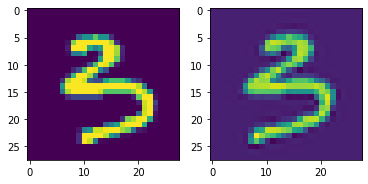

In [24]:
# The following moment and deskew functions were taken from the works of :

# https://stackoverflow.com/questions/43577665/deskew-mnist-images
# https://fsix.github.io/mnist/Deskewing.html

from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix
#Deskew the training samples 
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

print("shape of x_train is " + str(x_train.shape))
print("type of x_train is " + str(type(x_train)))
print("shape of x_test is " + str(x_test.shape))
print("type of x_test is " + str(type(x_test)))


#store the deskwed x_train into a list x_train_deskew
#store the deskwed x_test into a list x_test_deskew

#training set 
x_train_deskew = [] 
for i in range(x_train.shape[0]): 
    x_train_deskew.append(deskew(x_train[i].reshape(28,28)))
x_train_deskew = np.array(x_train_deskew)
x_train_deskew = x_train_deskew[..., np.newaxis]
print("shape of x_train_deskew is " + str(np.shape(x_train_deskew)))
print("type of x_train_deskew is " + str(type(x_train_deskew)))

#test set 
x_test_deskew = [] 
for j in range(x_test.shape[0]): 
    x_test_deskew.append(deskew(x_test[j].reshape(28,28)))
x_test_deskew = np.array(x_test_deskew)
x_test_deskew = x_test_deskew[..., np.newaxis]
print("shape of x_test_deskew is " + str(np.shape(x_test_deskew)))
print("type of x_test_deskew is " + str(type(x_test_deskew)))


#We should have the deskewed image stored within x_train
#original 
plt.subplot(1, 2, 1)
plt.imshow(x_train[3].reshape(28,28))

#deskewed 
plt.subplot(1, 2, 2)
plt.imshow(x_train_deskew[3])


#We should have the deskewed image stored within x_test 
#original
plt.subplot(1, 2, 1)
plt.imshow(x_test[3].reshape(28,28))

#deskewed
plt.subplot(1, 2, 2)
plt.imshow(x_test_deskew[3])

### Downsample image to 16 x 16
We will now downsample the image to make it embeddable in a quantum circuit.

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 16x16:


In [25]:
# 16x16 for angle embedding!
x_train_small_256 = tf.image.resize(x_train, (16,16)).numpy()
x_test_small_256 = tf.image.resize(x_test, (16,16)).numpy()


In [26]:
help(cirq.ry)

Help on function ry in module cirq.ops.common_gates:

ry(rads: Union[float, sympy.core.basic.Basic]) -> cirq.ops.common_gates.Ry
    Returns a gate with the matrix e^{-i Y rads / 2}.



## Angle Embedding
We will use angle embedding to encode the data on the qubits. We follow the procedure proposed by Chen et al(https://arxiv.org/pdf/2012.12177.pdf).
Here I would like to import the qBraid SDK to use the pennylane embedding angle embedding method, but that would mean I have to install tensorflow into that environment which would be a bitch.

$$\Sigma_{(q_1,q_2,...,q_N) \in (0,1)^N)} ||c_{q1} ... c_{qN}||^2 =1$$

The input will first be flattened and transformed into rotation
angles for the quantum gates (Chen et al).  In general, the input values of pixels are not in the interval
of [−1, 1]. We use the arc tangent function to transform these input values into rotation
angles.

In [53]:
"""Define a custom general unitary gatee with a parameter."""
class RotationGate(cirq.Gate):
    def __init__(self, alpha,beta, gamma):
        super(RotationGate, self)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def _num_qubits_(self):
        return 1

    def _unitary_(self):
        return np.array([
            [np.cos(self.alpha/2), -np.exp(self.gamma*1j)*np.sin(self.alpha/2)],
            [np.exp(self.beta*1j)*np.sin(self.alpha/2), np.exp(1j*(self.gamma+self.beta))*np.cos(self.alpha/2)]
        ])

    def _circuit_diagram_info_(self, args):
        return f"R({self.alpha,self.beta,self.gamma})"

In [54]:
"""Use the custom general unitary gate in our circuit."""
alpha = sympy.Symbol(f'alpha' + '_' + str(i))
circ = cirq.Circuit(
    
    RotationGate(alpha=alpha,beta=1,gamma=1).on(cirq.GridQubit(2,2))
)

print("Circuit with a custom rotation gate:")
print(circ)


Circuit with a custom rotation gate:
(2, 2): ───R((alpha_499, 1, 1))───


In [55]:
def angle_embed_image(image):
    values = np.ndarray.flatten(image)
    assert len(values) == 256
    qubits = cirq.GridQubit.rect(16, 16)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        x_i = np.arctan(value)
        x_i_squared = np.arctan(value**2)
        circuit.append(cirq.ry(x_i)(qubits[i]))
        circuit.append(cirq.rz(x_i_squared)(qubits[i]))
    return circuit

x_train_circ = [angle_embed_image(x) for x in x_train_small_256]
x_test_circ = [angle_embed_image(x) for x in x_test_small_256]

In [61]:
## Building the VQC
def qconv_layer(cirq_size=(16,16)):
    qubits = cirq.GridQubit.rect(cirq_size[0], cirq_size[1])
    circuit = cirq.Circuit()
    for i,_ in enumerate(qubits):
        if i < len(qubits)-1:
            circuit.append(cirq.CNOT(qubits[i],qubits[i+1]))
        else:
            circuit.append(cirq.CNOT(qubits[i],qubits[0]))
    for i, qubit in enumerate(qubits):
        alpha = sympy.Symbol(f'alpha' + '_' + str(i))
        beta = sympy.Symbol(f'beta' + '_' + str(i))
        gamma = sympy.Symbol(f'gamma' + '_' + str(i))
        circuit.append(RotationGate(alpha,beta,gamma).on(qubit))
        
    return circuit, cirq.Z(qubits[0])

In [62]:
model_circuit, model_readout = qconv_layer()


cirq.Z(cirq.GridQubit(0, 0))

In [72]:
tfq.util.get_supported_gates()

{cirq.X: 1,
 cirq.XX: 2,
 cirq.Y: 1,
 cirq.YY: 2,
 cirq.Z: 1,
 cirq.ZZ: 2,
 cirq.H: 1,
 cirq.CZ: 2,
 cirq.CNOT: 2,
 cirq.SWAP: 2,
 cirq.ISWAP: 2,
 cirq.PhasedXPowGate(phase_exponent=0.123): 1,
 cirq.PhasedISwapPowGate(phase_exponent=0.123): 2,
 cirq.FSimGate(theta=0.123, phi=0.456): 2,
 cirq.I: 1}

## Running model

In [74]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])


ValueError: Cannot serialize op <__main__.RotationGate object at 0x7ff592264400>.on(cirq.GridQubit(0, 1)) of type <class '__main__.RotationGate'>

## Results